## SFN 24 Analysis

### Imports

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from imports import *

In [15]:
from models import *
from data import * 
from env import *
from harmonize import *
from metrics import * 
from sim import *
from sim import multi_sim_run
from sim import plot

In [7]:
# overall imports
import importlib
import data

# data load
from data.data_load import load_transcriptome, load_connectome
importlib.reload(data.data_load)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# prebuilt model classes
import models.prebuilt_models
from models.prebuilt_models import ModelBuild
importlib.reload(models.prebuilt_models)

# metric classes
import metrics.distance_FC
import metrics.eval
from metrics.eval import ModelEvaluator
from metrics.eval import pearson_numpy, mse_numpy, r2_numpy, pearson_cupy, mse_cupy, r2_cupy
importlib.reload(metrics.eval)

# sim class
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
import sim.multi_sim_run
from sim.sim import Simulation
from sim.multi_sim_run import multi_sim_run, single_sim_run, open_pickled_results, combine_results
importlib.reload(sim.sim)
importlib.reload(sim.sim_utils)
importlib.reload(sim.multi_sim_run)

import sim.plot
from sim.plot import (
    plot_predictions, 
    barplot_model_performance,
    boxplot_model_performance,
    plot_predictions_with_metrics,
    plot_best_params_table, plot_best_parameters_table_colored, 
    violin_plot_model_performance, 
    plot_transcriptome_performance_bar, plot_connectome_performance_bar, 
    plot_combined_performance_bar
)

importlib.reload(sim.plot)


<module 'sim.plot' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/plot.py'>

#### Check job specs

In [9]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.showUtilization()


CPU Usage: 14.7%
RAM Usage: 7.0%
Available RAM: 468.0G
Total RAM: 503.0G
52.4G
GPU found 0
XGBoost version: 2.0.3
cupy version: 13.1.0
| ID | GPU | MEM |
------------------
|  0 |  0% |  4% |


## Table of Contents
- [Multidataset PLS](#PLS)
    - [AHBA+HCP](#AHBA)
    - [GTEx+HCP](#GTEx)
    - [UTSW+HCP](#UTSW)
- [AHBA+HCP](#AHBA)
    - [Bilinear PLS](#PLS-Sims)
      - [Random Splits](#PLS-Random-Splits)
    - [XGBoost](#XGBoost-Sims)
      - [Random Splits](#XGBoost-Random-Splits)

### Multidataset PLS

#### AHBA

In [74]:
X = load_transcriptome(dataset='AHBA')
Y = load_connectome(dataset='AHBA')

In [75]:
def fit_pls(X, Y, n_components):
    """Fit PLS model with specified number of components and return variance explained."""
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)

    # Predict on the training set
    Y_pred = pls.predict(X)

    # Calculate R² (variance explained) on the training set
    variance_explained = r2_score(Y, Y_pred)

    return pls, variance_explained

In [76]:
def run_pls_for_components(X, Y, max_components=20):
    """Fit PLS for multiple components and gather variance explained."""
    variances_explained = []

    # Fit PLS for each number of components
    for n_components in range(1, max_components + 1):
        _, variance_explained = fit_pls(X, Y, n_components)
        variances_explained.append(variance_explained)
        print(f"Components: {n_components}, Variance explained: {variance_explained}")

    return variances_explained


In [77]:

def plot_variance_explained(variances_explained, max_components=20):
    """Plot number of components vs variance explained."""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components + 1), variances_explained, label='Variance Explained (R²)', marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained (R²)')
    plt.title('Number of Components vs Variance Explained')
    plt.legend()
    plt.grid(True)
    plt.show()

In [85]:
def load_gene_names(file_name='allgenes_stable_r0.2_schaefer_100.csv'):
    """
    Load gene names from a CSV file.
    
    Parameters:
    file_name (str): The CSV file name containing gene names.
    
    Returns:
    np.ndarray: Array of gene names.
    """
    relative_data_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)    
    gene_file_path = os.path.join(relative_data_path, 'GeneEx2Conn/data', 'enigma', file_name)
    
    schaefer114_genes = pd.read_csv(gene_file_path)
    schaefer114_genes.set_index('label', inplace=True)
    gene_names = np.array(schaefer114_genes.columns.tolist())
    
    print(f'Loaded {len(gene_names)} gene names.')
    return gene_names

def get_feature_importances(X, Y, n_components=3):
    """Fit PLS and return a DataFrame of gene weights for the first 3 components."""
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)

    # Get weights for the first 3 components
    weights = pls.x_weights_[:, :3]  # Weights for components 1, 2, and 3

    # Load gene names
    gene_names = np.arange(0, X.shape[1], 1)# load_gene_names()

    # Create a DataFrame of feature importances (genes by component weights)
    feature_importances_df = pd.DataFrame(weights, index=gene_names, columns=[f'Component_{i+1}' for i in range(3)])
    
    return feature_importances_df
    
def normalize_components(df):
    """Normalize each component column to have values between 0 and 1."""
    normalized_df = df.copy()
    
    for column in normalized_df.columns:
        min_val = normalized_df[column].min()
        max_val = normalized_df[column].max()
        
        # Normalize to the range [0, 1]
        normalized_df[column] = (normalized_df[column] - min_val) / (max_val - min_val)
    
    return normalized_df


Components: 1, Variance explained: 0.17269528617251495
Components: 2, Variance explained: 0.2382253906932577
Components: 3, Variance explained: 0.2893838391109028
Components: 4, Variance explained: 0.36001005091476046
Components: 5, Variance explained: 0.3894282517782608
Components: 6, Variance explained: 0.4194429962282351
Components: 7, Variance explained: 0.4512820187322228
Components: 8, Variance explained: 0.47556418904104125
Components: 9, Variance explained: 0.5195969847997496
Components: 10, Variance explained: 0.5577210134082744


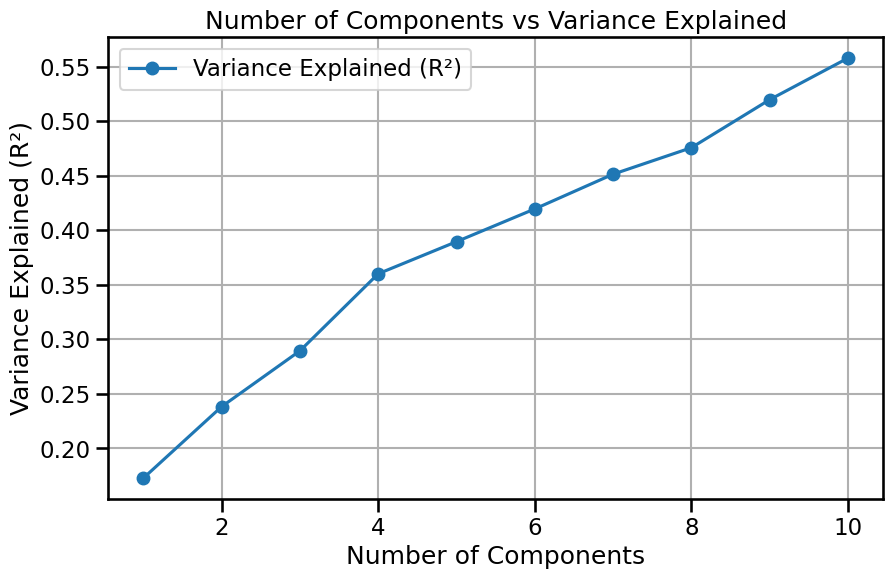

In [86]:
# Step 1: Load the data
X = load_transcriptome(dataset='AHBA')
Y = load_connectome(dataset='AHBA')

# Step 2: Run PLS for multiple components and get variance explained
max_components = 10
variances_explained = run_pls_for_components(X, Y, max_components)

# Step 3: Plot the number of components vs variance explained
plot_variance_explained(variances_explained, max_components)

ahba_feature_importances_df = get_feature_importances(X, Y, n_components=3)
ahba_normalized_importances_df = normalize_components(ahba_feature_importances_df)

#### GTEx

/scratch/asr655/neuroinformatics
Components: 1, Variance explained: 0.13696402626343804
Components: 2, Variance explained: 0.3299616450870909
Components: 3, Variance explained: 0.4321768911529551
Components: 4, Variance explained: 0.565359354539021
Components: 5, Variance explained: 0.7036924398359168
Components: 6, Variance explained: 0.8691477479821343
Components: 7, Variance explained: 1.0
Components: 8, Variance explained: 1.0
Components: 9, Variance explained: 1.0
Components: 10, Variance explained: 1.0


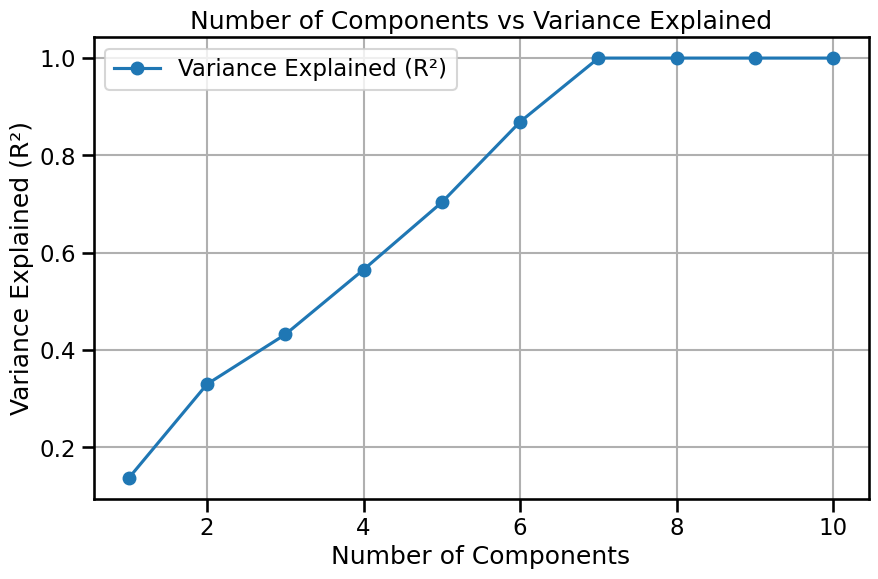

In [87]:
X = load_transcriptome(dataset='GTEx')
Y = load_connectome(dataset='GTEx')

# Step 2: Run PLS for multiple components and get variance explained
max_components = 10
variances_explained = run_pls_for_components(X, Y, max_components)

# Step 3: Plot the number of components vs variance explained
plot_variance_explained(variances_explained, max_components)

# Step 4: Fit PLS for the optimal number of components and save weights
optimal_components = 5  # Set based on analysis from the plot
save_pls_weights(X, Y, n_components=optimal_components, save_path='pls_first_component_weights.csv')


gtex_feature_importances_df = get_feature_importances(X, Y, n_components=3)
gtex_normalized_importances_df = normalize_components(gtex_feature_importances_df)

#### UTSW

Components: 1, Variance explained: 0.14416221888628505
Components: 2, Variance explained: 0.2609250598681544
Components: 3, Variance explained: 0.37723598294978933
Components: 4, Variance explained: 0.5176886615079771
Components: 5, Variance explained: 0.6500272446030027
Components: 6, Variance explained: 0.7525941375253418
Components: 7, Variance explained: 0.87189800296156
Components: 8, Variance explained: 0.961949087518129
Components: 9, Variance explained: 0.9999999517062186
Components: 10, Variance explained: 1.0


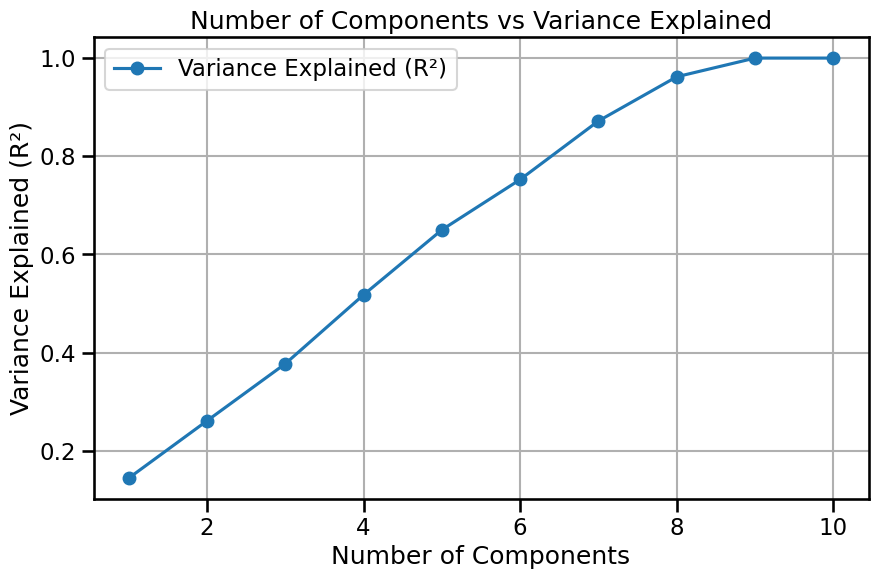

In [88]:
X = load_transcriptome(dataset='UTSW')
Y = load_connectome(dataset='UTSW')

# Step 2: Run PLS for multiple components and get variance explained
max_components = 10
variances_explained = run_pls_for_components(X, Y, max_components)

# Step 3: Plot the number of components vs variance explained
plot_variance_explained(variances_explained, max_components)

utsw_feature_importances_df = get_feature_importances(X, Y, n_components=3)
utsw_normalized_importances_df = normalize_components(utsw_feature_importances_df)

#### Evaluate PLS similarity across datasets

In [ ]:
# need to get common gene list for the 3 datasets here

### AHBA PLS <a id="PLS-Sims"></a>

#### 4-Fold Random split

In [44]:
full_pls_random_shared_sim_results = multi_sim_run('random',
                                                'pls',
                                                use_gpu=False, 
                                                use_shared_regions=False, 
                                                test_shared_regions=False, 
                                                save_sim=True,
                                                search_method='grid'
                                                )


Number of components explaining 95% of the variance: 34

 Test fold num: 1
(7140, 170) (7140,) (812, 170) (812,)
2
3
4
Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END max_iter=1000, n_components=1, scale=True, tol=1e-07; total time=   0.0s[CV] END max_iter=1000, n_components=1, scale=False, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=3, scale=False, tol=1e-07; total time=   0.1s

[CV] END max_iter=1000, n_components=5, scale=True, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=3, scale=True, tol=1e-07; total time=   0.2s
[CV] END max_iter=1000, n_components=5, scale=False, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=7, scale=False, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=7, scale=True, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=9, scale=False, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=9, scale=True, tol=1e-07; total time=   

In [6]:
multi_sim_random_pls = open_pickled_results('multi_sim_random_pls.pickle')

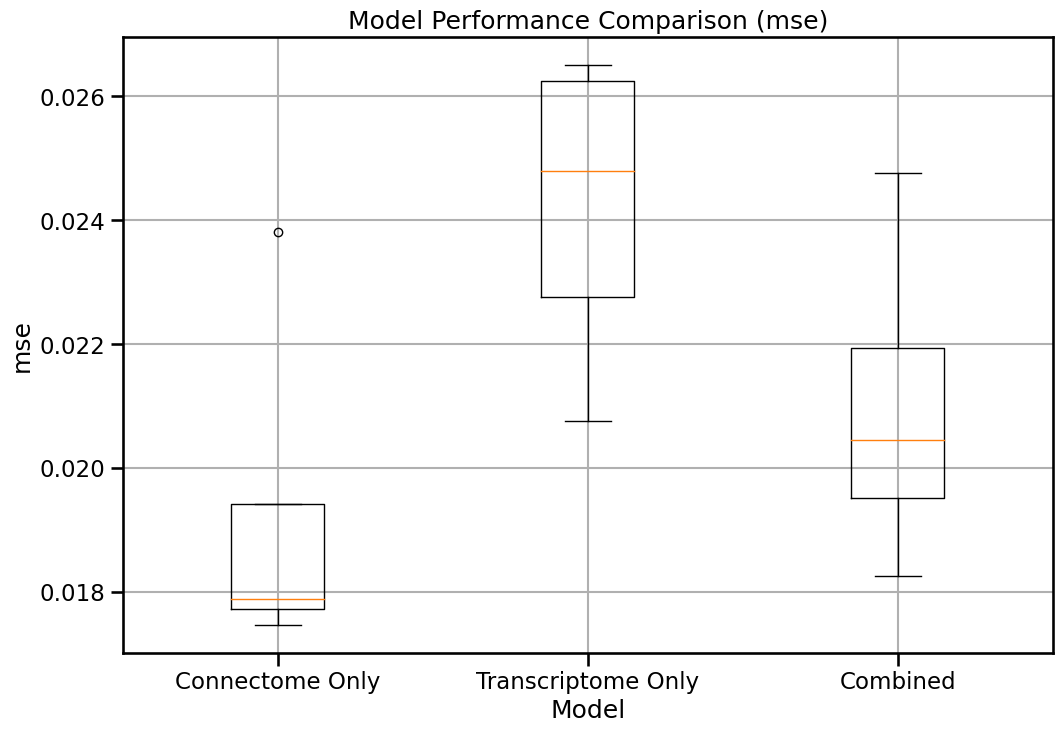

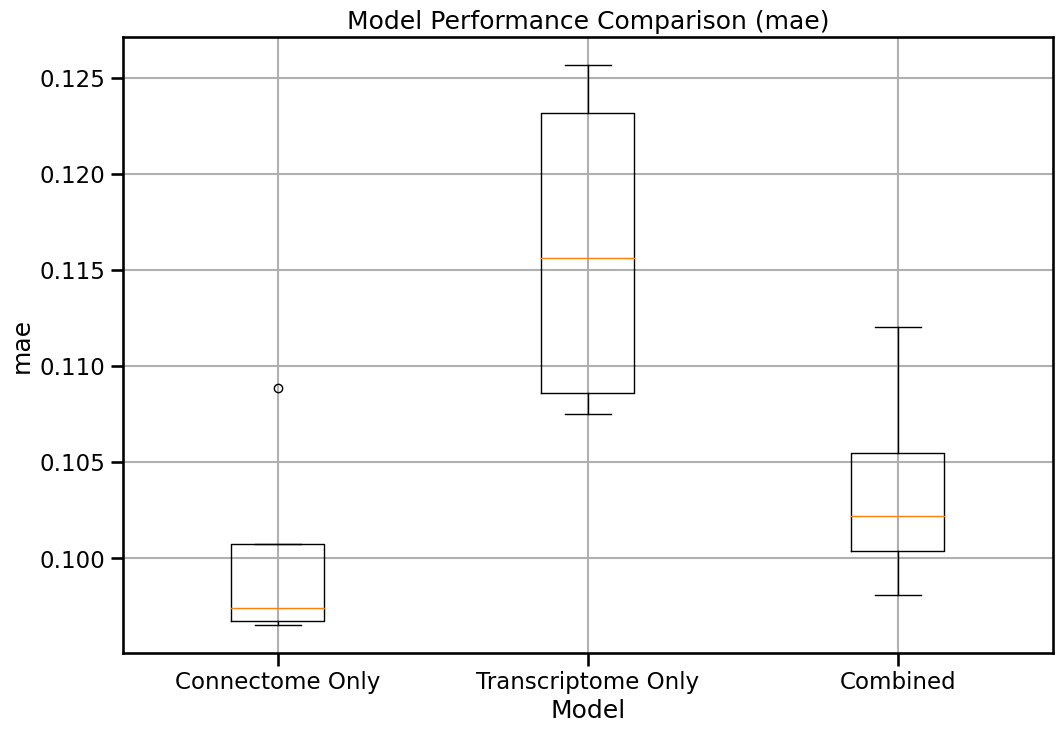

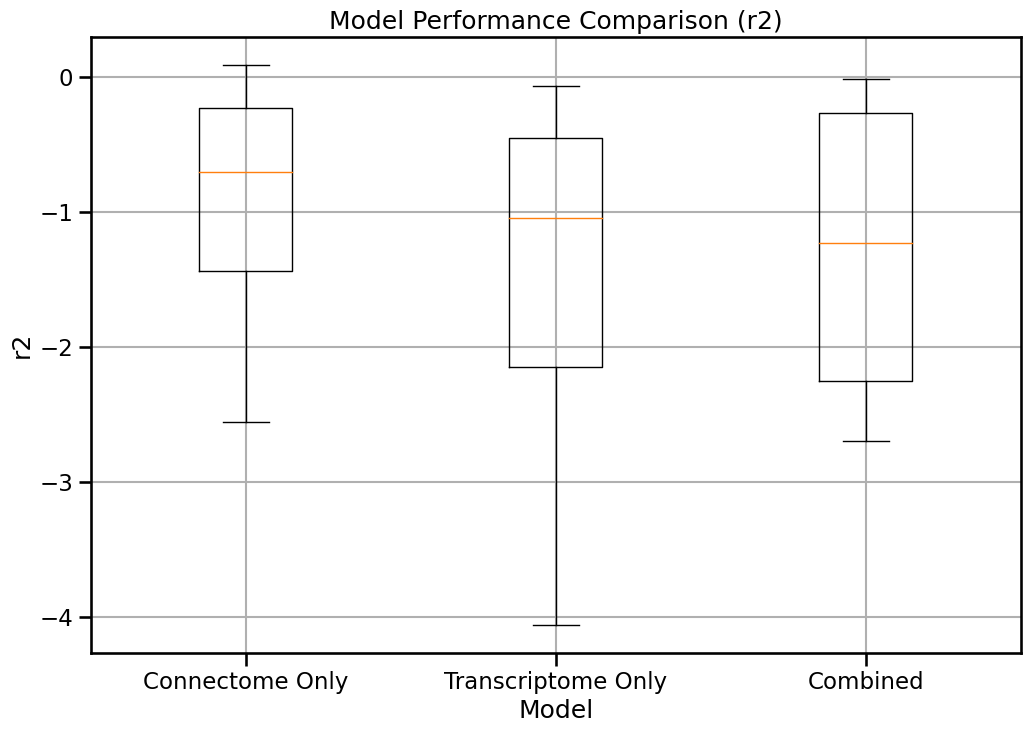

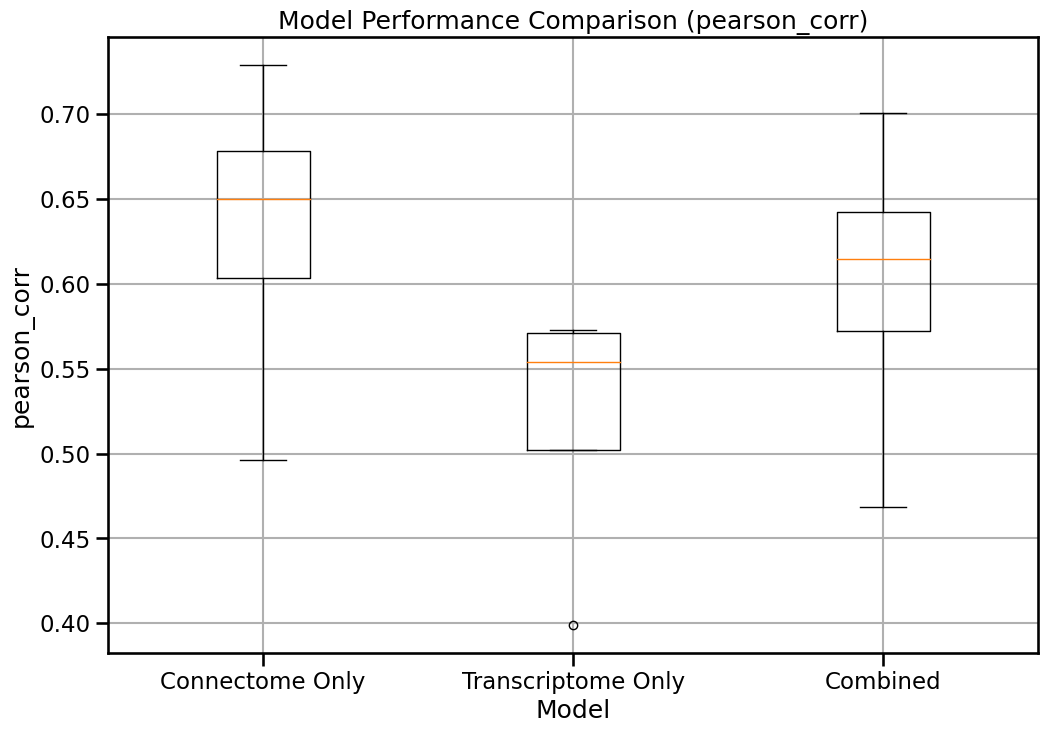

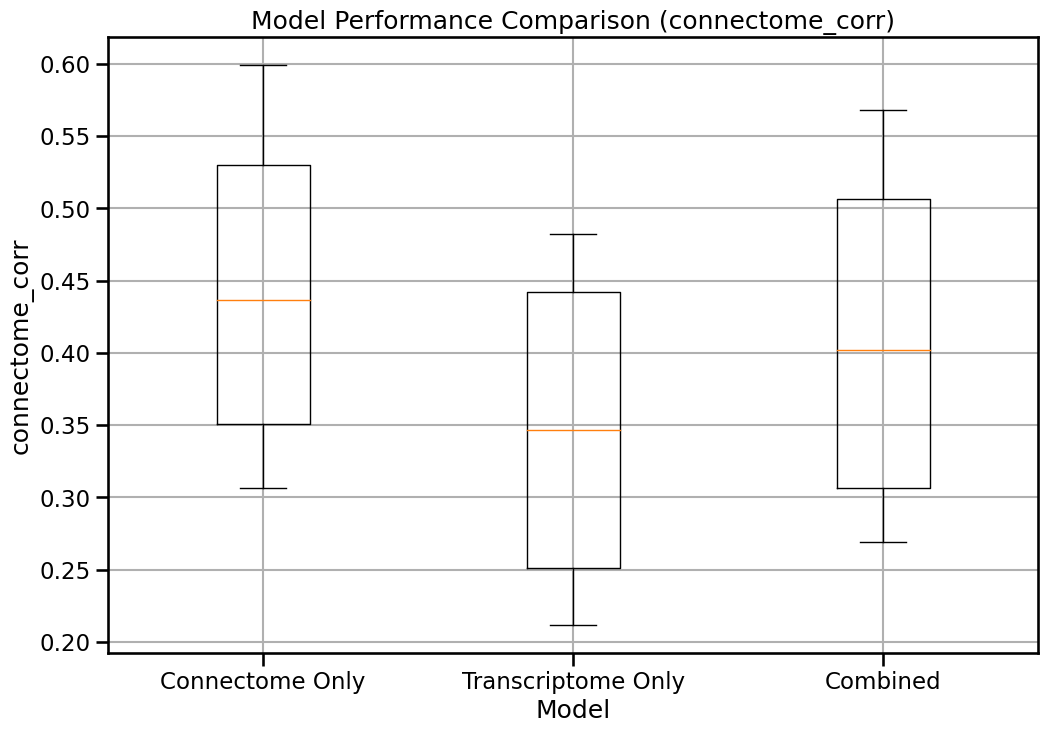

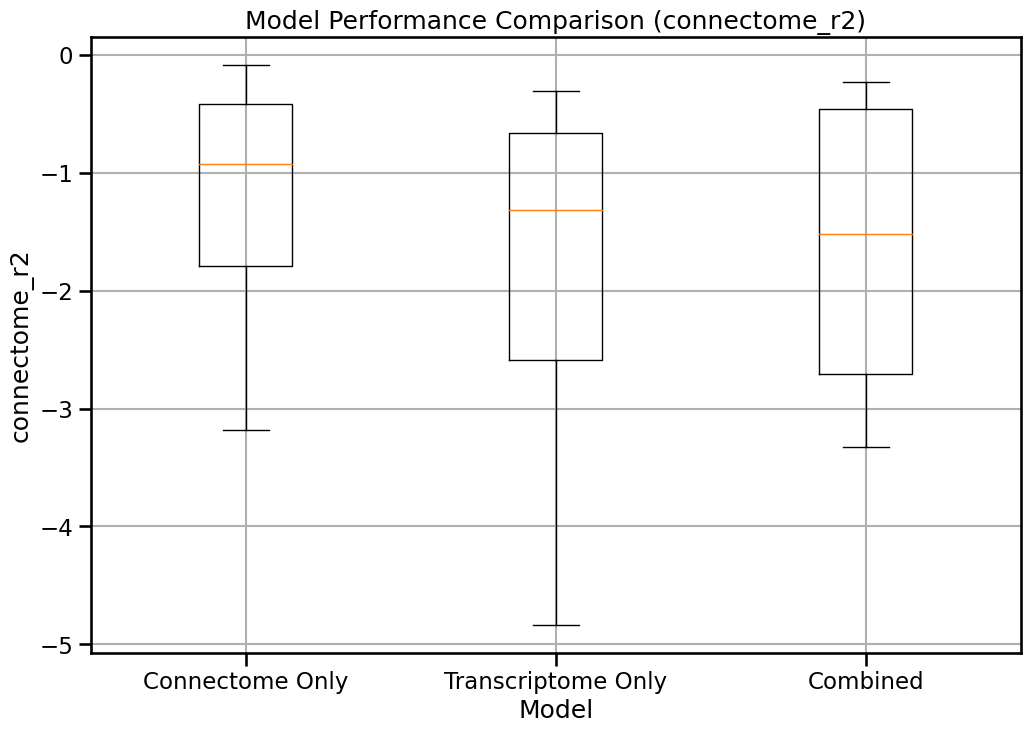

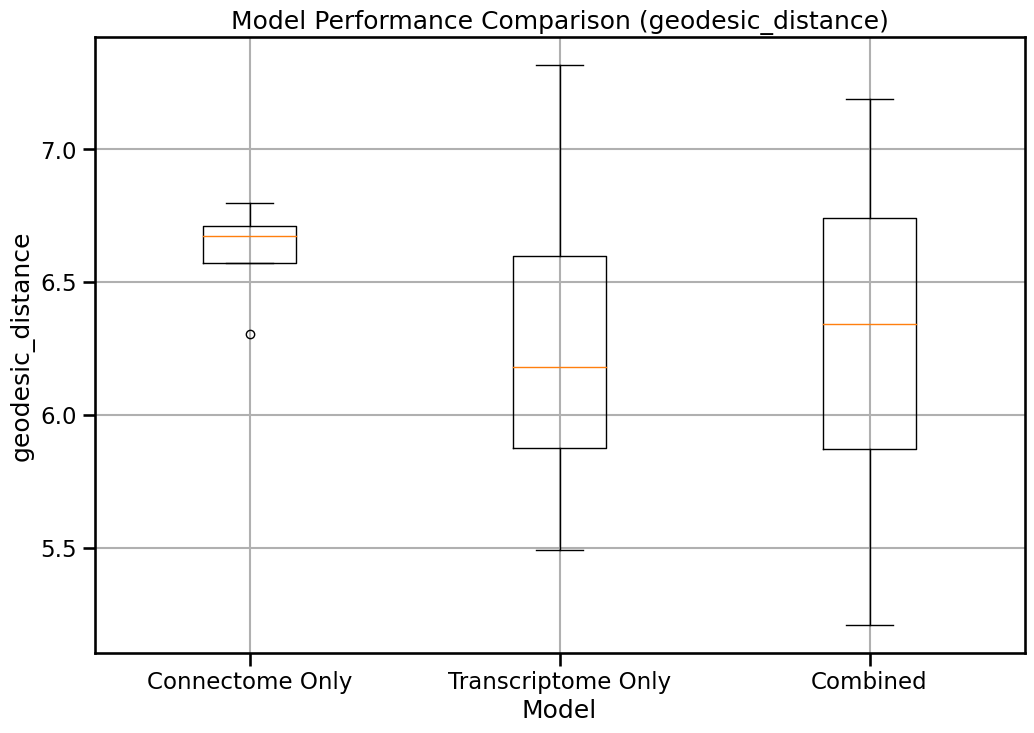

In [7]:
boxplot_model_performance(multi_sim_random_pls)

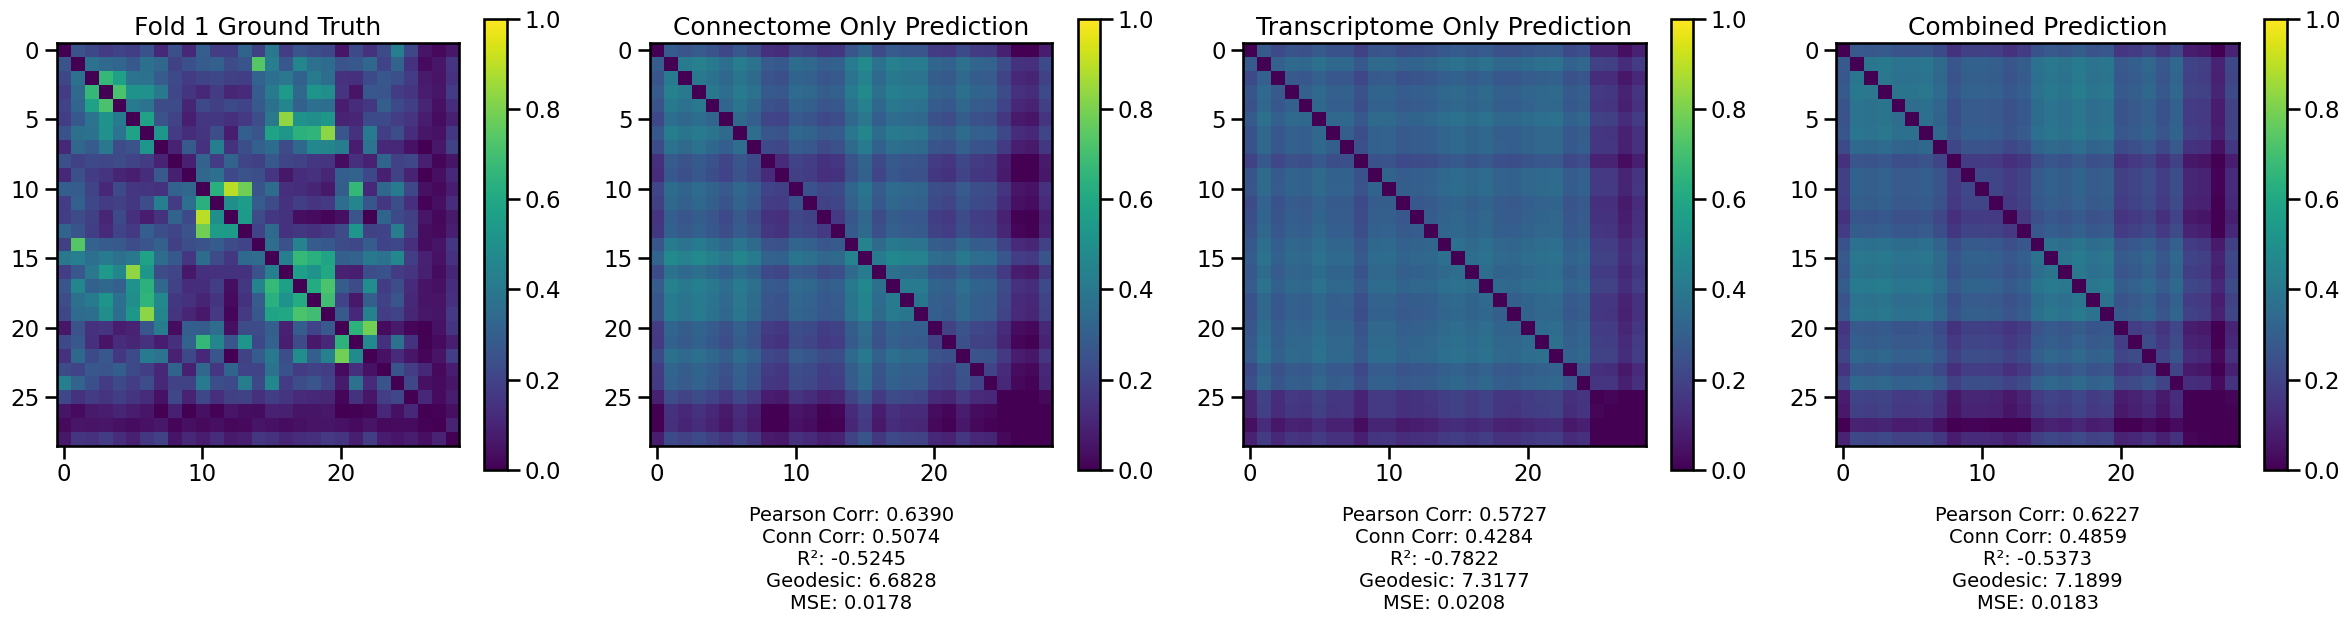

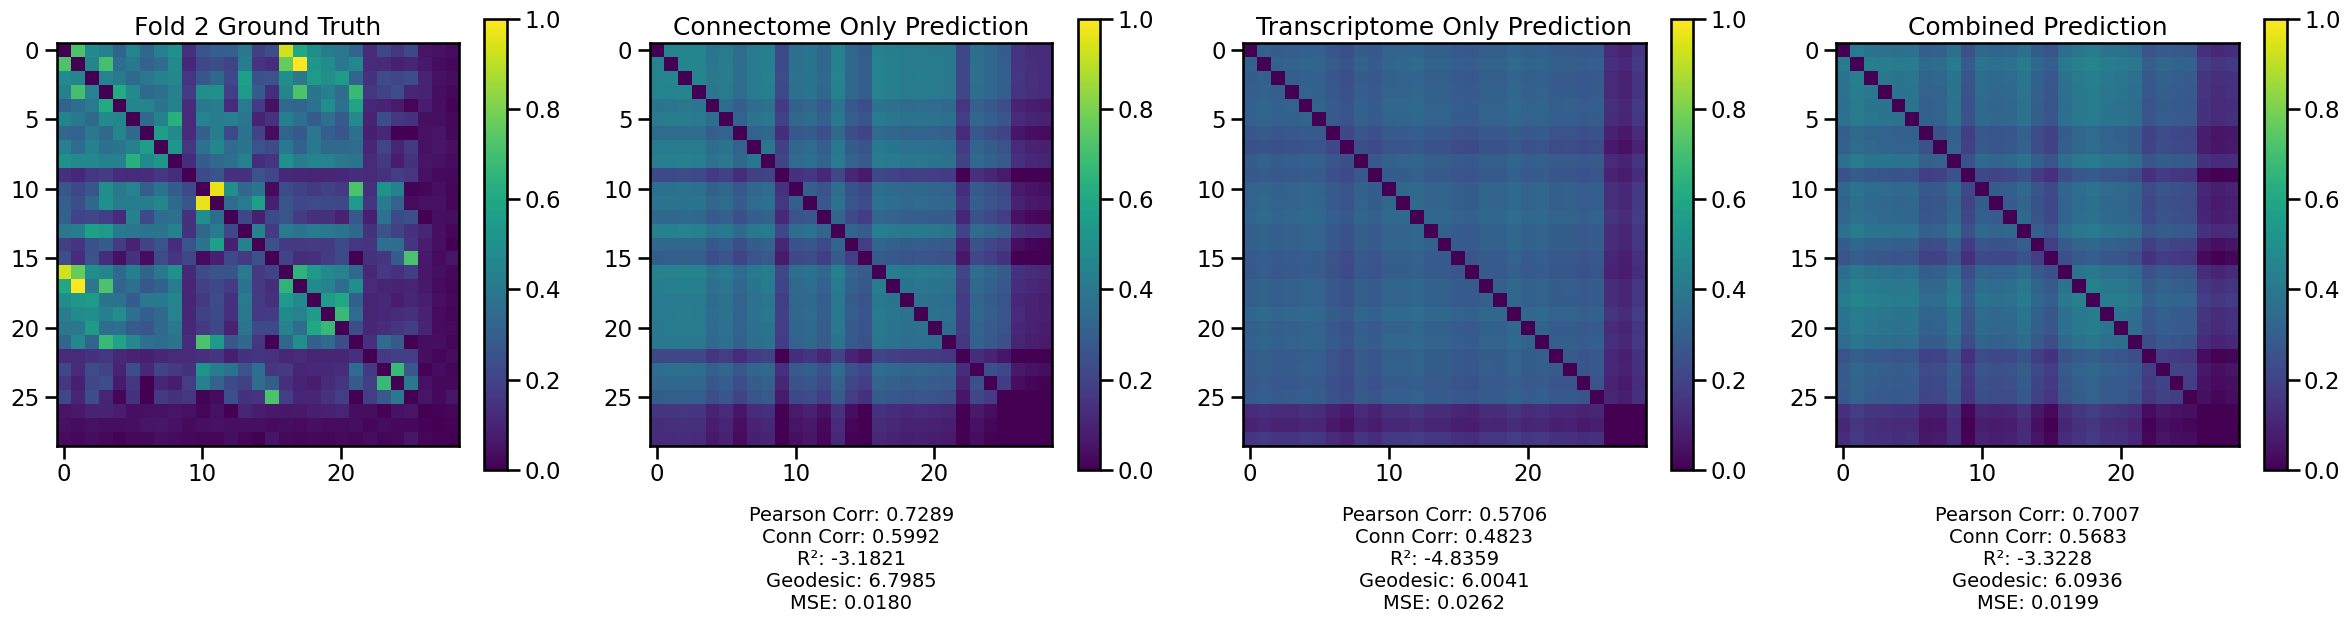

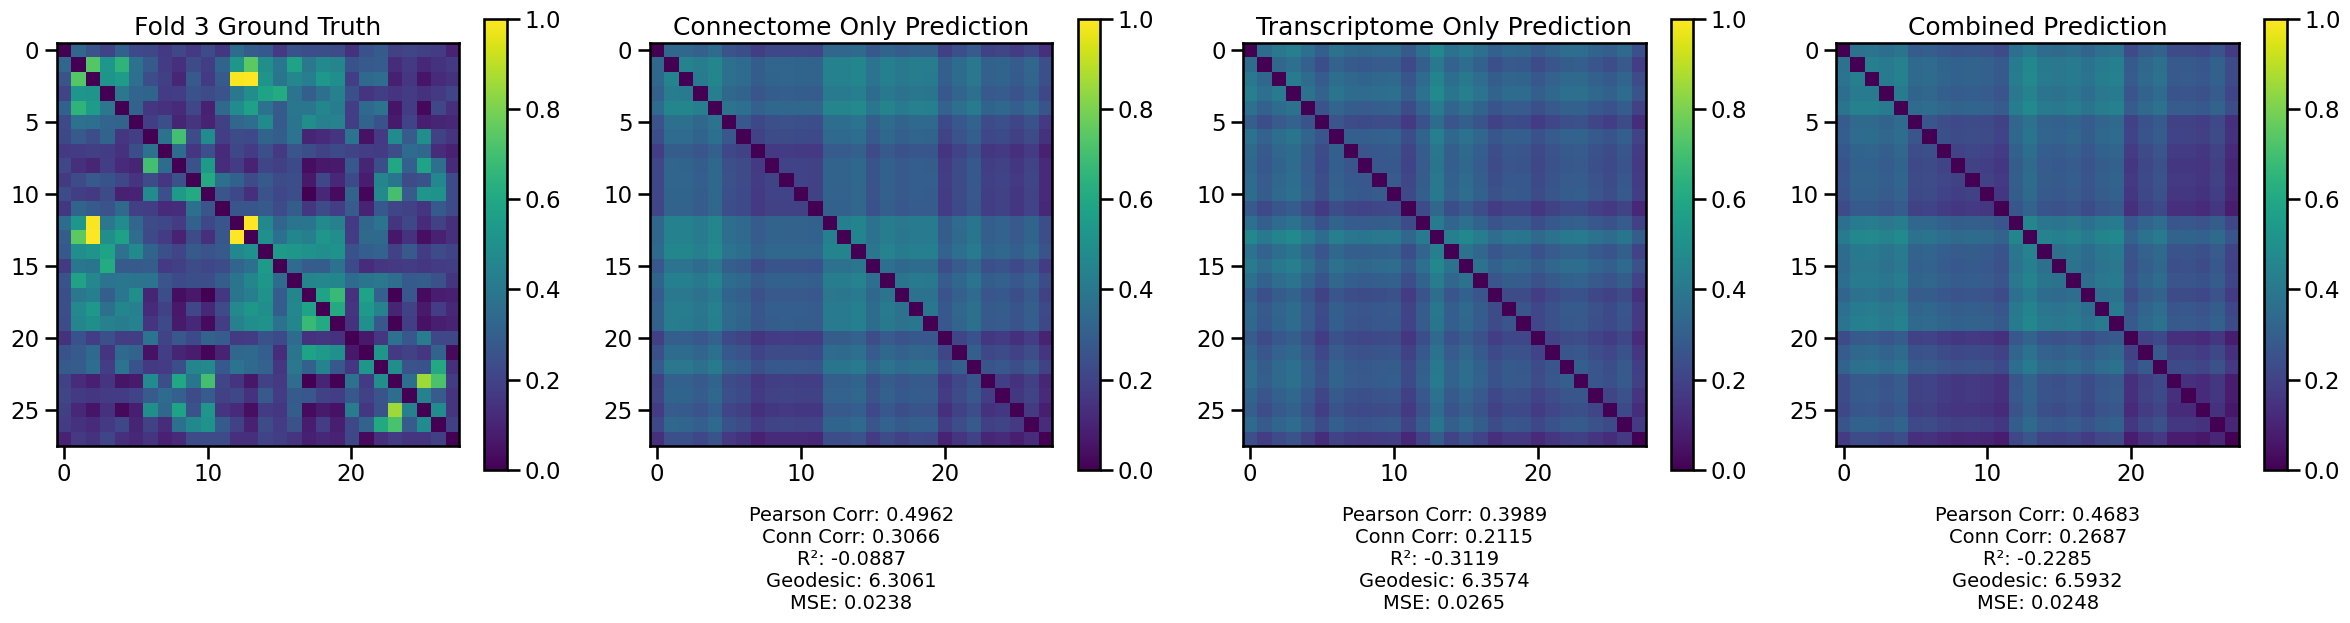

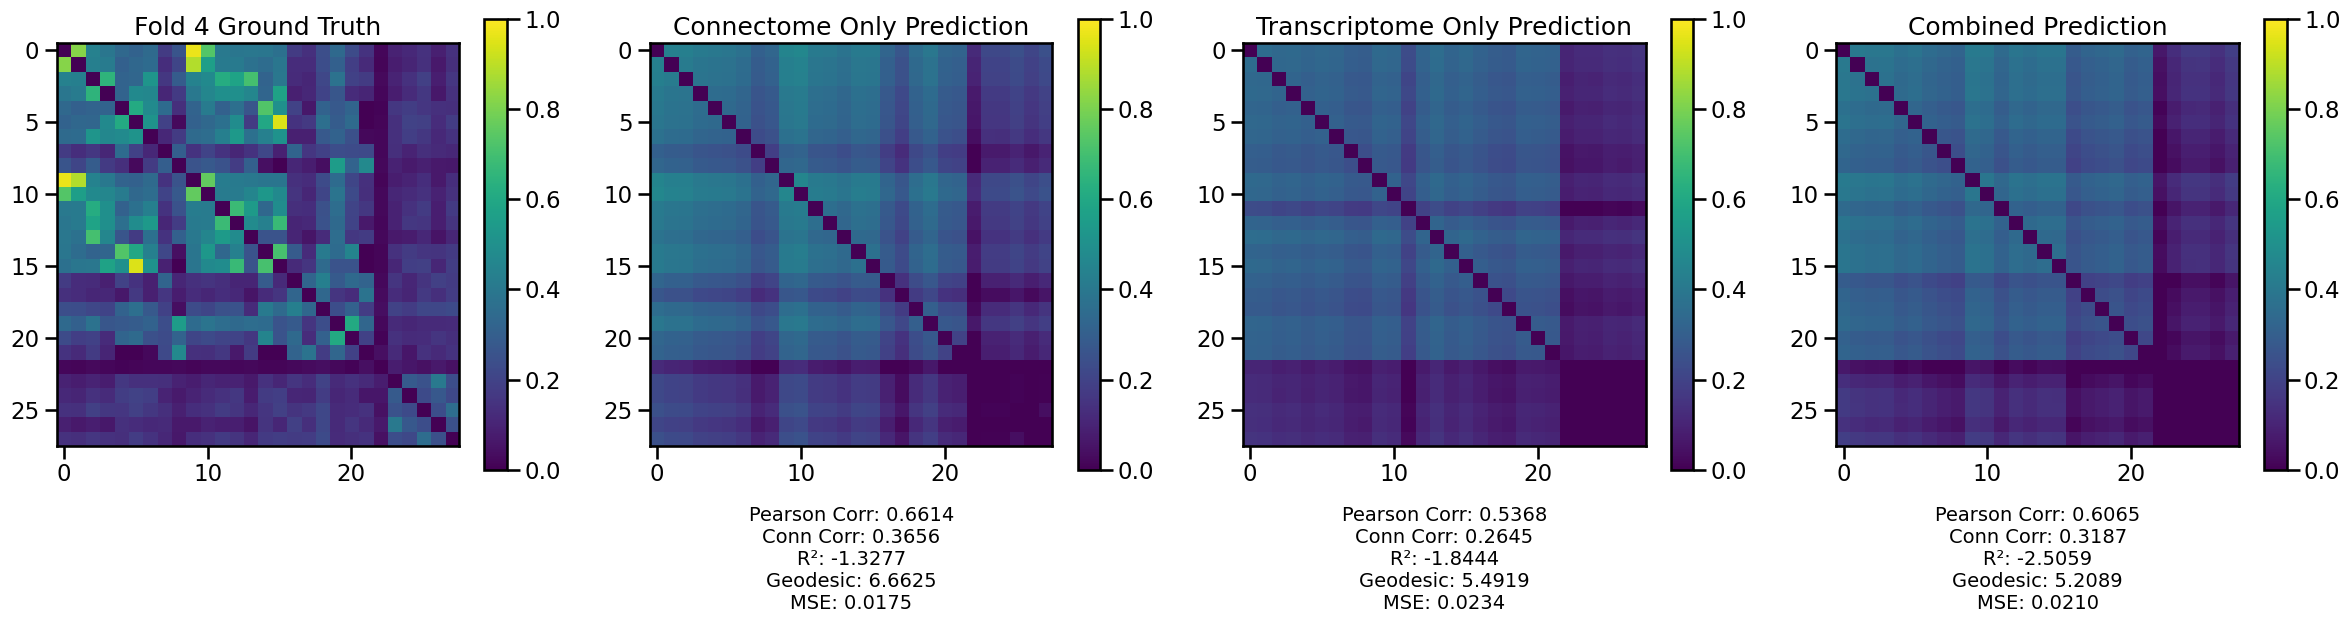

In [8]:
plot_predictions_with_metrics(multi_sim_random_pls)

### AHBA XGBoost <a id="XGBoost-Sims"></a>

#### 4-Fold Random split

Random split, trained on non-shared regions, test on non-shared

In [8]:
full_xgb_random_nonshared_sim_results = multi_sim_run('random',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False, 
                                              save_sim=True,
                                              search_method='random'
                                              )

Number of components explaining 95% of the variance: 34

 Test fold num: 1
(7140, 170) (7140,) (812, 170) (812,)
2
3
4


CUDARuntimeError: cudaErrorNoDevice: no CUDA-capable device is detected

In [11]:
trans_xgb_random_nonshared_sim_results = single_sim_run(cv_type='random',
                                              model_type='xgboost',
                                              feature_type='trans only',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False, 
                                              save_sim=True,
                                              search_method='bayes'
                                              )

Number of components explaining 95% of the variance: 34
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(7140, 22106) (7140,) (812, 22106) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
ACCELERATING
{'base_estimator': 'GP', 'acq_func': 'PI'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.01, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.481 total time=   2.2s
[CV 2/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.01, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.351 total time=   2.2s
[CV 3/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0

In [10]:
transplusconn_xgb_random_nonshared_sim_results = single_sim_run(cv_type='random',
                                              model_type='xgboost',
                                              feature_type='trans plus conn',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False, 
                                              save_sim=True,
                                              search_method='random'
                                              )

Number of components explaining 95% of the variance: 34
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(7140, 22276) (7140,) (812, 22276) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV 1/1] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=5, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0, reg_lambda=0, subsample=0.8, tree_method=gpu_hist, verbosity=0;, score=0.780 total time=   2.7s
[CV 1/1] END colsample_bytree=1, device=cuda, learning_rate=0.1, max_depth=2, n_estimators=350, n_gpus=-1, random_state=42, reg_alpha=1, reg_lambda=0, subsample=0.8, tree_method=gpu_hist, verbosity=0;, score=0.817 total time=   1.5s
[CV 1/1] END colsample_bytree=0.8, device=cuda, learning_rate=0.1, max_depth=4, n_estimators=150, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=0.8, tree_method=gpu_hist, verbosi

Functions to combine single sim results

In [22]:
# File names
conn_file = 'single_sim_conn_random_xgboost.pickle'
# trans_file = 'single_sim_trans_rsearch_random_xgboost.pickle'
trans_file = 'single_sim_trans_bsearch_random_xgboost.pickle'
transconn_file = 'single_sim_transplusconn_random_xgboost.pickle'
output_file = 'multi_sim_random_xgboost_combined.pickle'

# Combine the results
combine_results(conn_file, trans_file, transconn_file, output_file)

Combined results saved to ./sim/sim_results/multi_sim_random_xgboost_combined.pickle


In [23]:
multi_sim_random_xgb = multi_sim_run.open_pickled_results('multi_sim_random_xgboost_combined.pickle')

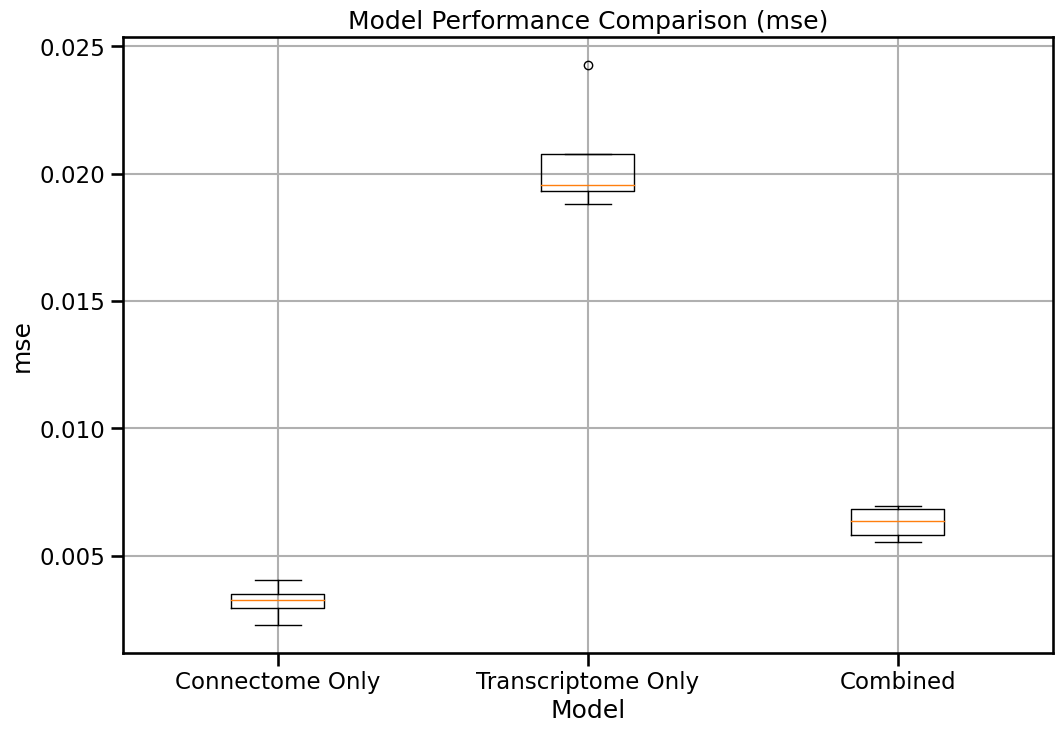

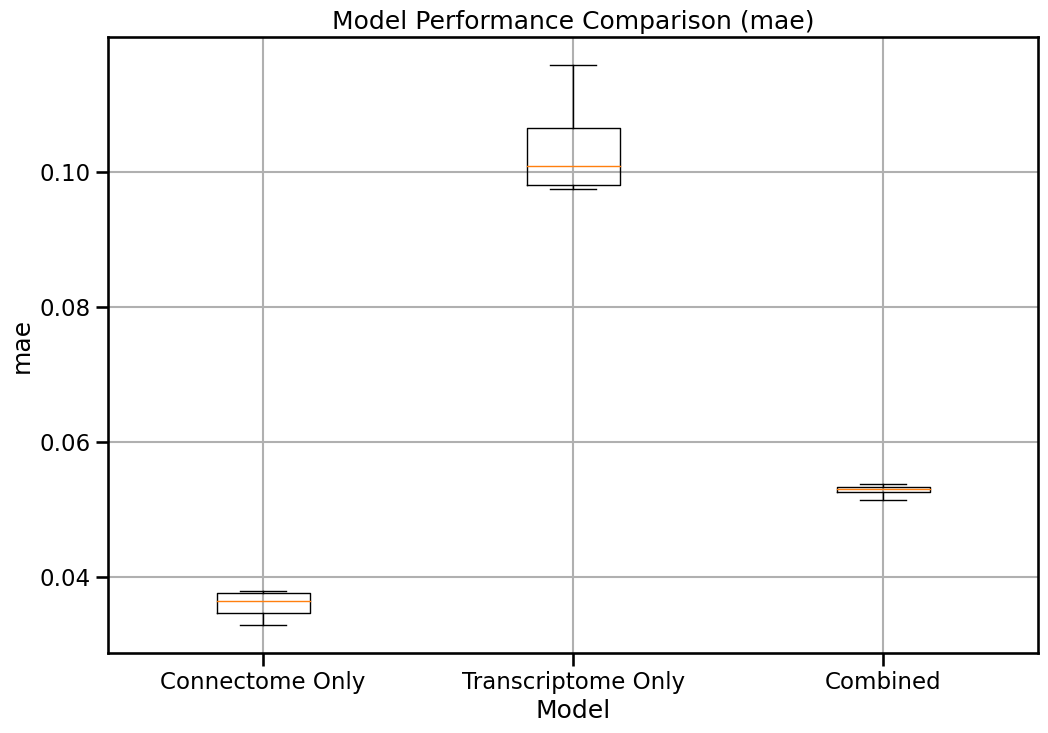

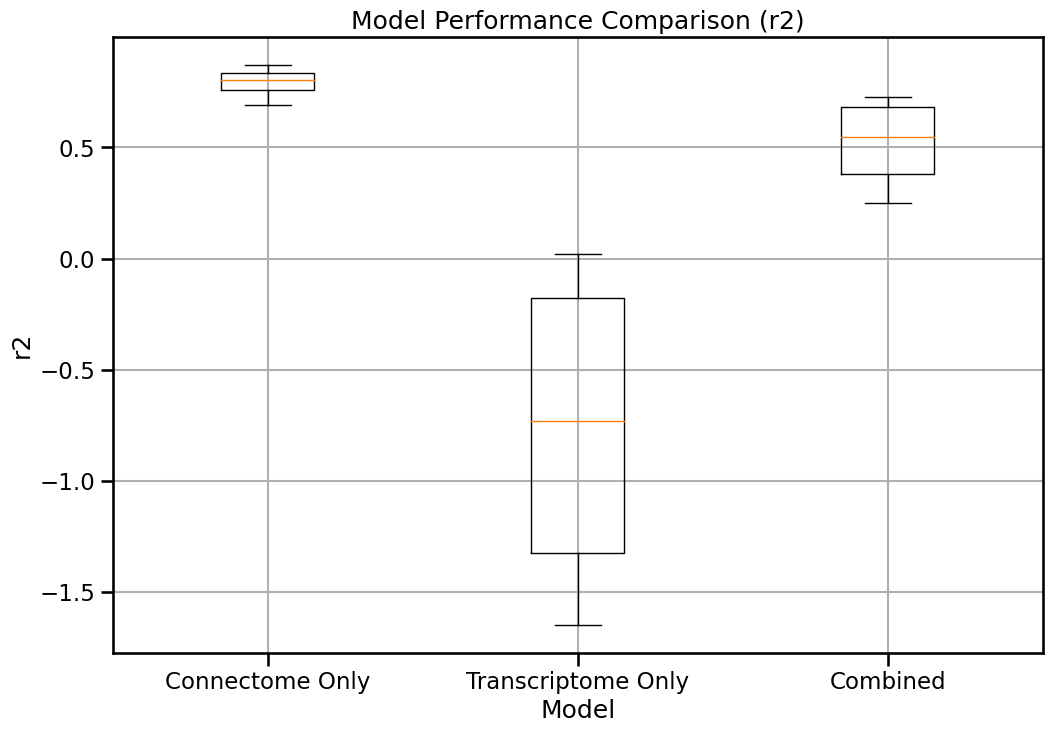

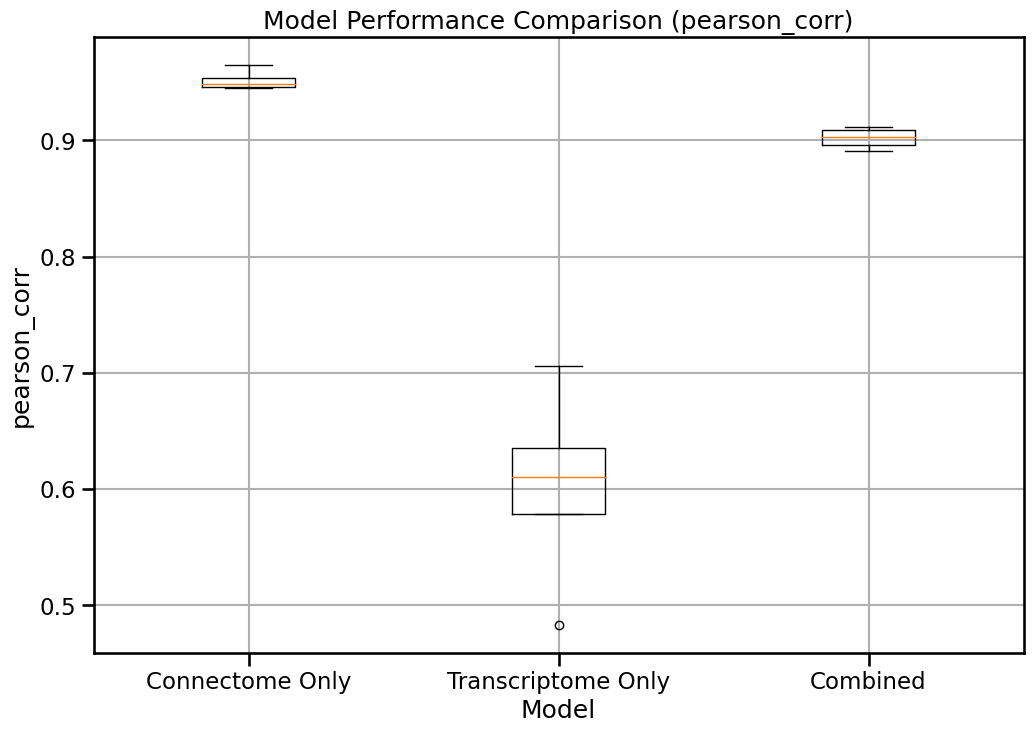

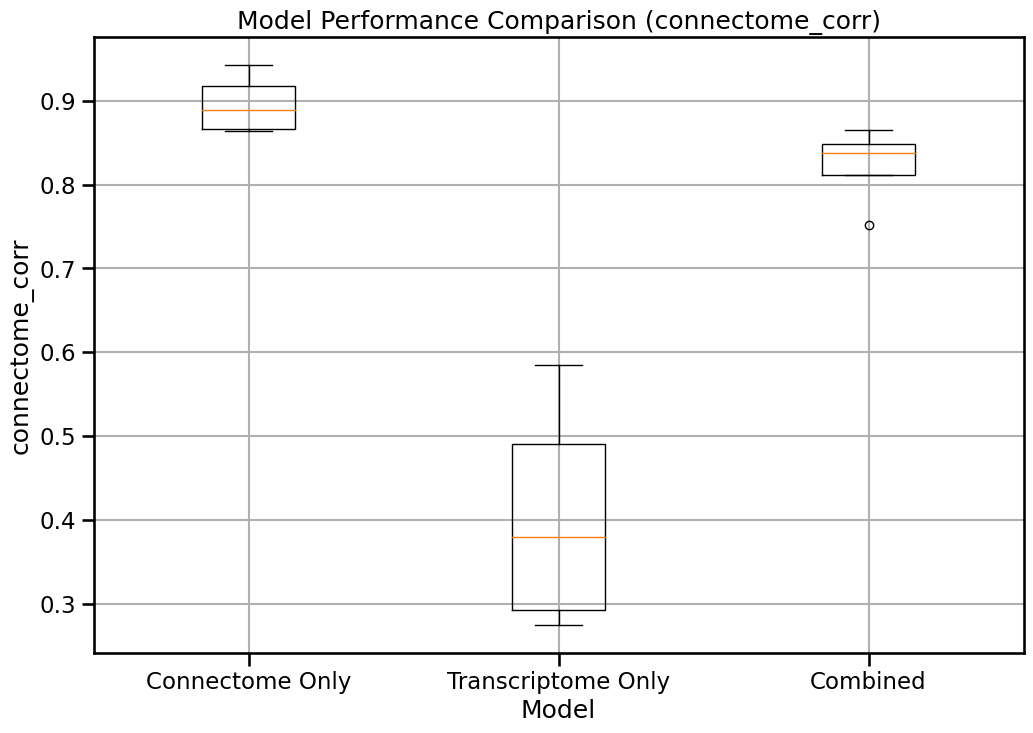

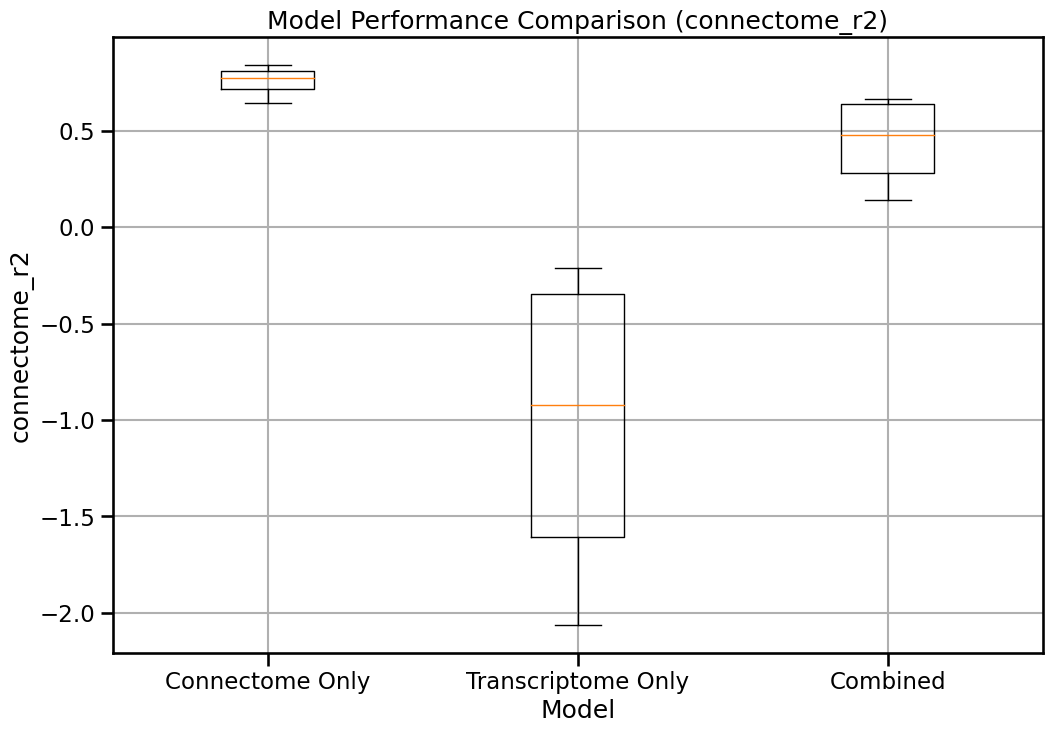

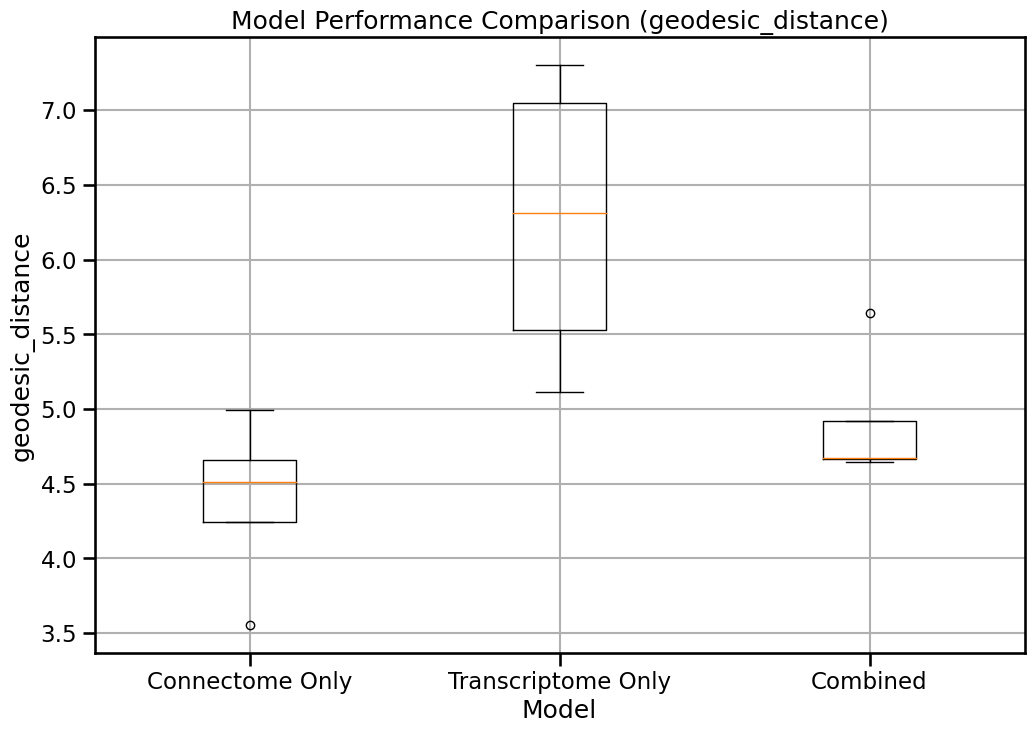

In [24]:
boxplot_model_performance(multi_sim_random_xgb)

In [ ]:
plot_predictions_with_metrics(multi_sim_random_xgb)

High accuracy transcriptome replication

In [ ]:
# This is the high accuracy replication
trans_xgb_random_nonshared_sim_results = single_sim_run(cv_type='random',
                                              model_type='xgboost',
                                              feature_type='trans only',
                                              use_gpu=True,
                                              use_shared_regions=True,
                                              test_shared_regions=False, 
                                              save_sim=True,
                                              search_method='bayes'
                                              )

Number of components explaining 95% of the variance: 34
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(12070, 22106) (12070,) (812, 22106) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
ACCELERATING
